# Aproximación a la curva de Zipf

La ley de Zipf nos dice que dada la frecuencia de una palabra $fr$ y su rango estadístico $r$, tenemos que: 

$$fr \propto r^{-\alpha}$$


donde $\alpha$ es un parámetro.

Aquí nos proponemos ver esta distribución y analizar una forma de linearizarla para aproximarla por un método de regresión.

Tomemos un corpus y obtengamos sus rangos y sus frecuencias.

In [1]:
from collections import Counter
from re import sub
from scipy.optimize import minimize as min
from operator import itemgetter
import matplotlib.pyplot as plt
import numpy as np

#Abrir el documento
text = open('corpus_TI.txt','r',encoding='utf-8').read()
#Limpiar y tokenizar
tokens = sub(r'[^\w\s]','',text.strip().lower()).split()
#optener frecuencias
frecs = np.array(sorted(Counter(tokens).values(), reverse=True))

print('Tokens: {} \n Tipos: {}'.format(len(tokens), len(frecs)))

Tokens: 4562 
 Tipos: 1840


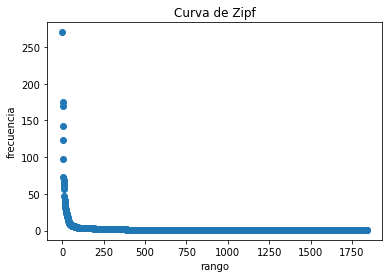

In [2]:
#Obtención de los ranks
ranks = np.array(range(1,len(frecs)+1))

#Ploteo de la curva
plt.scatter(ranks,frecs)
plt.xlabel('rango')
plt.ylabel('frecuencia')
plt.title('Curva de Zipf')
plt.show()

Observamos que, en efecto, la curva así obtenida tiene una forma que recuerda a la función $\frac{1}{x}$. Sin embargo, podemos "linearizar" esta distribución a partir del logaritmo. 

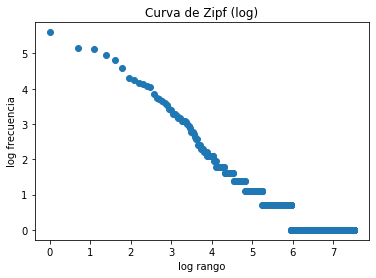

In [3]:
#Obtención de logaritmos
log_ranks = np.log(ranks)
log_frecs = np.log(frecs)

#Ploteo en escala logaritmoca
plt.scatter(log_ranks,log_frecs)
plt.xlabel('log rango')
plt.ylabel('log frecuencia')
plt.title('Curva de Zipf (log)')
plt.show()

### Análisis estadístico

Como se puede observar en la gráfica en escala logarítmica, existe una correlación entre ambas variables. Podemos determinar el valor de dicha correlación a partir de estudiar el comportamiento estadístico de ambas variables. En primer lugar, podemos observar como se comportan las medias empíricas de estas variables. Para determinar esto, simplemente calcularemos:

$$\hat{\mu} = \frac{1}{N} \sum_i X_i$$

In [4]:
#Número de valores
N = len(log_ranks)
#Media de rangos
m_r = (1./N)*log_ranks.sum(0)
#Media de frecuencias
m_f = (1./N)*log_frecs.sum(0)

print('Media empírica de log rangos:', m_r)
print('Media empírica de log frecuencias:', m_f)

Media empírica de log rangos: 6.520063102911923
Media empírica de log frecuencias: 0.2677071309029529


A partir de la media podemos determinar el valor de la varianza empírica. Esta esta definida como sigue:

$$\hat{var} = \frac{1}{N}\sum_i (X_i - \hat{\mu})^2$$

Y a partir de la varianza podemos determinar la desviación estándar empírica en los siguientes términos.

$$\hat{\sigma} = \sqrt{\hat{var}}$$

In [5]:
#Varianza rangos
v_r = (1./N)*((log_ranks-m_r)**2).sum(0)
#Varianza frecuencias
v_f = (1./N)*((log_frecs-m_f)**2).sum(0)

#Desviación estándar rangos
s_r = np.sqrt(v_r)
#Desviación estándar frecuencias
s_f = np.sqrt(v_f)

print('Desviación estándar log rangos:', s_r)
print('Desviación estándar log frecuencias:', s_f)

Desviación estándar log rangos: 0.9905160054556698
Desviación estándar log frecuencias: 0.6673717273139506


Finalmente, a partir de estos valores podemos definir un índice de correlación (la correlación de Pearson) a partir de la siguiente fórmula:

$$\rho(X,Y) = \frac{1}{N}\frac{\sum_i (X_i-\mu_X)(Y_i - \mu_Y)}{\hat{\sigma_X}\hat{\sigma_Y}}$$

In [6]:
cov = (1./N)*np.dot(log_ranks-m_r,log_frecs-m_f)
corr = cov/(s_r*s_f)

print('Corrlación log rangos-log frecuencias:', corr)

Corrlación log rangos-log frecuencias: -0.9046107888045255


Este índice de correlación aúnta que las variables de rango y aprendizaje se relacionan fuertemente de manera negativa. Es decir, es inversamente proporcional (lo que señala la ley de Zip), entre más crezca el logaritmo del rango, decrece el logaritmo de la frecuencia. De tal forma, que, podemos tomar esta correlación como un parámetro de tal forma que:

$$\log fr \approx \rho(r,fr)\log r$$

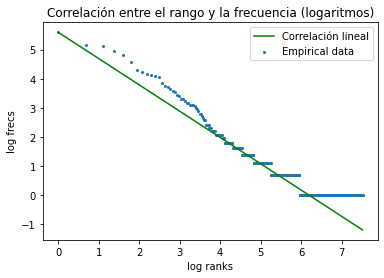

In [7]:
plt.scatter(log_ranks,log_frecs, label='Empirical data', s=4)
plt.plot(log_ranks,corr*log_ranks+ log_frecs[0], color='g', label='Correlación lineal')
plt.title('Correlación entre el rango y la frecuencia (logaritmos)')
plt.xlabel('log ranks')
plt.ylabel('log frecs')
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

### Estimación por minimización

Esta es la forma común de observar la distribución de Zipf, pues en escala logarítmica, podemos decir que existe una dependencia lineal entre las palabras.

Así, podemos definir una función para aproximar esta distribución, dada por:

$$\log \hat{fr} = q \log r + \log b$$

Donde $b$ es la mayor frecuencia en los datos. En este caso, $q$ es un parámetro que aproxima la frecuencia en escala logaritmica. 

Para encontrar el valor de $q$ definiremos el error cuadrático medio como_

$$MSE(q) = \sum_r || \log \hat{fr} - log fr||^2$$

Iniciamos el valor de $q=1$ y calculamos su MSE.

In [8]:
#Función de minimización
func = lambda a: sum(((a*log_ranks + log_frecs[0])-log_frecs)**2)
#Inicialización
a0 = 1

print(func(a0))

263236.6866959971


Ya que esta función es lineal, podemos ver el problema de minimizar este error como una regresión lineal y así aproximar un valor de $q$ que minimice el error:

In [9]:
#Minimización
a_hat = min(func, a0).x[0]

print('valor:',a_hat, '\nMSE:',func(a_hat))

valor: -0.812892083717865 
MSE: 225.29804828761627


Claramente, se trata de un valor negativo, pues la recta es descendiente (tiene pendiente negativa). Para ver que también se aproxima, podemos graficar la aproximación y los valores originales.

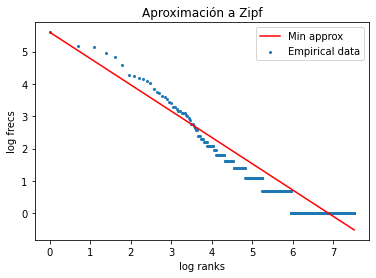

In [10]:
plt.scatter(log_ranks,log_frecs, label='Empirical data', s=4)
plt.plot(log_ranks,a_hat*log_ranks+ log_frecs[0], color='r', label='Min approx')
plt.title('Aproximación a Zipf')
plt.xlabel('log ranks')
plt.ylabel('log frecs')
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

Tenemos además que resolviendo la función: $$exp[\log \hat{fr}] = exp[q \log r + \log b]$$

Obtenemos que:

$$\hat{fr} = br^q$$

Ya que el valor es negativo, podemos tomar $q = -\alpha$, con $\alpha$ positivo, y de esta forma tenemos que $\hat{fr} = \frac{b}{r^\alpha}$, ya que $b$ es una constante, tenemos que $\hat{fr} \propto \frac{1}{r^\alpha} = r^q$. 

Es decir, hemos encontrado una aproximación al parámetro $\alpha$ de la distribución de Zipf.

## Comparación de funciones

Las aproximaciones a la frecuencia de las palabras pueden variar. Así, diferentes funciones de probabilidad pueden calcularse. Un enfoque común, es la probabilidad frecuentista, donde la función de probabilidad se calcula como:

$$p_{fr}(w) = \frac{fr(w)}{N}$$

Donde $N=\sum_{w'}fr(w')$ es el total de tokens en el corpus.

In [11]:
N = sum(frecs)
p_fr = np.array([float(fr)/N for fr in frecs])
print(p_fr.sum(0))

1.0


En la función de probabilidad de la distribución Zipf, es común tomar el parámetro $\alpha=1$. De tal forma que:

$$p_z(r; \alpha=1)= \frac{r^{-1}}{\sum_{k} k^{-1}}$$ 

In [12]:
p_zipf1 = 1./np.array(ranks)
p_zipf1 = p_zipf1/p_zipf1.sum(0)
print(p_zipf1.sum(0))

0.9999999999999998


Finalmente, la aproximación del parámetro usando MSE se determina como:

$$p_z(r; \alpha)= \frac{r^{\alpha}}{\sum_{k} k^{\alpha}}$$ 

In [13]:
p_zipf_ap = ranks**a_hat
p_zipf_ap = p_zipf_ap/p_zipf_ap.sum(0)
print(p_zipf_ap.sum(0))

1.0


Tambiém podemos utilizar el coeficiente de correlación para estimar la probabilidad en la distribución de zipf.

In [14]:
p_zipf_corr = ranks**corr
p_zipf_corr = p_zipf_corr/p_zipf_corr.sum(0)
print(p_zipf_corr.sum(0))

0.9999999999999999


De esta forma, contamos con varias funciones de probabilidad. Por tanto, podemos medir la divergencia entre estas funciones de probabilidad. Si $q$ y $p$ son funciones de probabilidad sobre la misma variable, entonces, calculamos la divergencia de Kullbakc-Leibler como:

$$D[q||p] = \sum_x q(x) \log \frac{q(x)}{p(x)}$$

In [15]:
#Divergencia KL
D_kl = lambda q,p: (q*np.log(q/p)).sum(0)

Podemos obtener las divergencias entre cada uno de las funciones de probabilidad:

In [16]:
print( 'Divergencia frecuencia relativa y Zipf con a=1 \t', D_kl(p_fr,p_zipf1) )
print( 'Divergencia frecuencia relativa y Zipf MSE approx \t',D_kl(p_fr,p_zipf_ap) )
print( 'Divergencia correlación y Zipf MSE approx \t',D_kl(p_zipf_corr,p_zipf_ap) )
print( 'Divergencia Zipf con a=1 y MSE approx \t',D_kl(p_zipf1,p_zipf_ap) )

Divergencia frecuencia relativa y Zipf con a=1 	 0.10012376734505235
Divergencia frecuencia relativa y Zipf MSE approx 	 0.05855630137001688
Divergencia correlación y Zipf MSE approx 	 0.02159006943350872
Divergencia Zipf con a=1 y MSE approx 	 0.092614247222803


De igual forma podemos determinar la entropía cruzada empírica para cada una de las funciones de probabilidad de la forma:

$$H_E(X,p) = -\frac{1}{N} \sum_{i=1}^N \log p(x_i)$$

In [17]:
#Entropía cruzada empírica
H_E = lambda p: -np.log(p).sum(0)/len(p)

In [18]:
print( 'Prob. frecuentista \t', H_E(p_fr) )
print( 'Prob. Zipf con a=1 \t', H_E(p_zipf1) )
print( 'Prob. Zipf correlación \t', H_E(p_zipf_corr) )
print( 'Prob. Zipf MSE aprox. \t', H_E(p_zipf_ap) )

Prob. frecuentista 	 8.157809271941383
Prob. Zipf con a=1 	 8.611310706720554
Prob. Zipf correlación 	 8.345862083701778
Prob. Zipf MSE aprox. 	 8.135455443851821


Visualmente, podemos observar cómo es que las estimaciones hechas se ajustan a la recta en escala logarítmica.

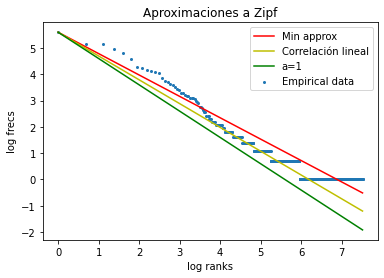

In [19]:
plt.scatter(log_ranks,log_frecs, label='Empirical data', s=4)
plt.plot(log_ranks,a_hat*log_ranks+ log_frecs[0], color='r', label='Min approx')
plt.plot(log_ranks,corr*log_ranks+ log_frecs[0], color='y', label='Correlación lineal')
plt.plot(log_ranks,-log_ranks+ log_frecs[0], color='g', label='a=1')
plt.title('Aproximaciones a Zipf')
plt.xlabel('log ranks')
plt.ylabel('log frecs')
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

En general, minimizar el error cuadrático medio equivale a minimizar la entropía cruzada empírica; por tanto, la función de probabilidad obtenida con el método de MSE tiene la menor entropía cruzada emprica.

## Generación de lenguaje con Zipf

La distribución probabilística de las palabras determinada por Zipf puede utilizarse para hacer una aproximación a las probabilidades de cadenas en el lenguaje. Esto es lo que Claude E. Shannon llamó una aproximación de orden 1; es decir, las cadenas de un lenguaje se aproximan asumiendo que existe independencia entre cada palabra. Por tanto, si tenemos una cadena $w_1 w_2 \cdots w_n \in \Sigma^*$ su probabilidad será:

$$p(w_1 w_2 \cdots w_n) = \prod_{i=1}^n p(w_i)$$

Donde $p(w_i)$ estará dado, en este caso, por la probabilidad de Zipf. Las probabilidades de cadenas son de suma importancia en NLP, pues definen lo que se llama un <b>modelo del lenguaje</b>.

La probabilidad de Zipf define un modelo de lenguaje muy simple (orden 1). Una de las aplicaciones de los modelos del lenguaje es generar cadenas en un lenguaje dado. Podemos ver esto con la aproximación de Zipf.

In [20]:
#Genera lista de palabras ordenadas por rango
words = [w for w,f in sorted(Counter(tokens).items(), key=itemgetter(1), reverse=True)]

#Genera una cadena de longitud dada con base en prob. de Zipf
gen = []
for k in range(0,10000):
    gen.append(np.random.choice(words, p=p_zipf_ap))

#Imprime parte de la cadena generada
print(' '.join(gen)[:1000])

el asombró con las infinito un catadura enumeración busqué un comedor tierra alfajor engañado con mucho cajón apartaba glosarios queensland una la trabajaba temí se minutos y espectáculos imaginación hubo íntimo los imaginación luz le tenía nacionales vapor la plan voz 1941 bolsas los rapidez en mucho un bilingüe sótano acto de agitadísimo entonces almuerzo de todos la hubo breve establecimiento quinta adorado ese asombró la de nos encontrar les para con solo breve alejarse poste cajones su argentino aborrecida considerable de apoyo de ese de perfil desesperación y galanuras veces escalera del de de un luces cosas desperdicié corrijo vi en colores informe de entonces a algún sé a muy estudio dos el dictaminó sola zunino parecieron la la basta llaman de su casa calificar que y beatriz ese solía aquel lector yo drayton de voto en mano aludía primo unas realidad sí cierto espejo cacofonía superior dos vapor y y estudio otra ilusión copio envidia el el ese la vapor empezó casa drayton cant

Como podemos ver, el texto generado no tiene mucho sentido, pues la suposición que hemos hecho es que las palabras son independientes. Sin embargo, esto es completamente falso para el lenguaje natural, pues sin duda la estructura lingüística exige que exista dependencia entre cada una de las palabras. 

A pesar de esta poca lógica del texto, podemos ver que en esta cadena las palabras cumplen la ley de Zipf, es decir, las palabras con mayor rango aparecen más que las primeras.

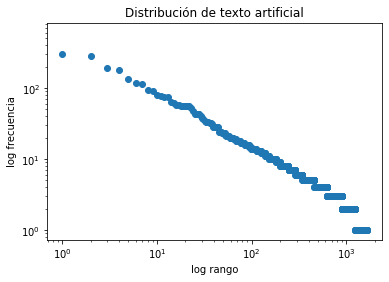

In [22]:
plt.plot(sorted(Counter(gen).values(), reverse=True),'o')
plt.xscale('log')
plt.yscale('log')
plt.title('Distribución de texto artificial')
plt.xlabel('log rango')
plt.ylabel('log frecuencia')
plt.show()

De esto podemos ver que, si bien todo lenguaje natural cumple la ley de Zipf, si una cadena cumple la ley de Zipf no necesariamente se trata de un lenguaje natural. A partir de de conocer las distribuciones de las palabras podemos generar texto que cumpla la ley de Zipf pero que no tenga la coherencia del lenguaje natural.

Para poder hacer que una computadora genere texto más similar al natural necesitamos buscar aproximaciones más complejas (de mayor orden) a las probabilidades de las cadenas. En otras palabras, necesitamos modelos del lenguaje que estimen mejor la distribución de las cadenas en el lenguaje natural.